In [1]:
import os
import numpy as np
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt
from  multiprocessing import Pool
from functools import partial
from astropy.table import Table
from astropy import units as u
from matplotlib import colors
plt.style.use('jpg.mplstyle')

import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.image as afwImage

import lsst.log
Log = lsst.log.Log()
Log.setLevel(lsst.log.ERROR)

import lsst.daf.persistence
import lsst.afw.display.rgb as afwRgb
import lsstutils
from hugs.utils import mkdir_if_needed, angsep
ROOT = '/tigress/HSC/DR/s18a_wide'


def _get_skymap(root=ROOT):
    butler = lsst.daf.persistence.Butler(root)
    skymap = butler.get('deepCoadd_skyMap', immediate=True)
    return butler, skymap


def _draw_ellipse(ra, dec, ell_pars, wcs, ax, color='c', **kwargs):
    r_e, theta, ell, scale = ell_pars
    r_e_pix = r_e/0.168
    q = 1.0 - ell
    diam = 2*r_e_pix
    x, y = wcs.skyToPixel(lsstutils.make_afw_coords([ra, dec]))
    e = Ellipse([x, y], scale*diam, scale*diam*q, angle=theta,
                ec=color, fc='none', lw=1.5, ls='--', **kwargs)
    ax.add_patch(e)
    
def single_rgb_image(ra, dec, radius, prefix, Q=8., dataRange=0.6, scale=20,
                     file_format='png', img_size=None, butler=None,
                     skymap=None, root=ROOT, dpi=150, ell_pars=None,
                     full_cat=None, ell_scale=1):

    if butler is None:
        butler, skymap = _get_skymap(root)

    try:
        img, wcs = lsstutils.make_rgb_image(
            ra, dec, radius, Q=Q, dataRange=dataRange,
            butler=butler, skymap=skymap, img_size=img_size,
            return_wcs=True)
    except:
        print('WARNING: failed to get {} at {}, {}'.format(prefix, ra, dec))
        return None

    return img, wcs



In [2]:
butler, skymap = _get_skymap(root=ROOT)

In [3]:
cat = Table.read('/tigress/jgreco/hsc-s18a/hugs-run/hugs-s18a-02/catalog/hugs-s18a-02.csv')

In [47]:

subcat = cat[(cat['ra'] > 0) & (cat['ra'] < 1)].copy()

idx = np.random.randint(0, len(subcat)-1)



stamps = {}
for b in 'gri':
    try:
        stamp = lsstutils.make_stamp(subcat[idx]['ra'], subcat[idx]['dec'], 40, b,
                                     root=ROOT, skymap=skymap, butler=butler)
        stamps[b] = stamp
    except:
        print(b, 'failed')
        stamps[b] = None

i failed


In [59]:
subcat['viz-id'] = np.arange(len(subcat))

In [90]:
rand_idx = np.random.choice(np.arange(len(subcat)), size=20, replace=False)
subcat[rand_idx].write('/scratch/gpfs/jgreco/random-fail-patches.csv', overwrite=True)

In [87]:
exp_1 = butler.get('deepCoadd_calexp', tract=9469, patch='2,7', filter='HSC-I')

In [88]:
exp_1.getImage().getArray()

array([[-0.0814928 , -0.01070495,  0.038165  , ..., -0.04955889,
         0.00607675,  0.1123032 ],
       [-0.03328874, -0.00039582,  0.07565279, ...,  0.18240365,
         0.05538501,  0.07301822],
       [ 0.00394145, -0.05972064,  0.02240212, ..., -0.04628486,
         0.11048106,  0.00913117],
       ...,
       [-0.04671727,  0.09900003,  0.01317752, ...,  0.01906043,
        -0.10411104,  0.0176744 ],
       [-0.07195166,  0.07285571,  0.05554067, ...,  0.03271269,
        -0.04840964, -0.03286259],
       [-0.02828998, -0.03111087,  0.0798125 , ...,  0.0829845 ,
         0.08605146, -0.00582071]], dtype=float32)

In [50]:
subcat[idx]['ra'], subcat[idx]['dec']

(0.7269047, -0.704318)

In [49]:
subcat[idx]['ra', 'dec', 'tract', 'patch']

<Row index=38>
    ra       dec    tract patch
 float64   float64  int64  str3
--------- --------- ----- -----
0.7269047 -0.704318  9227   8,4

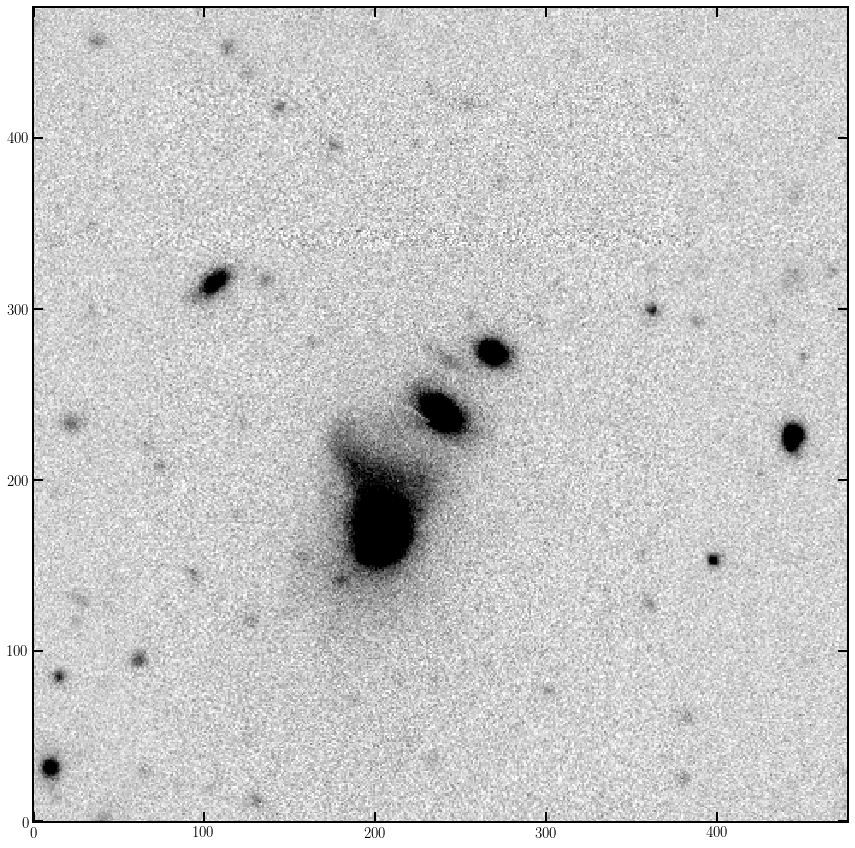

In [7]:
exp = stamps['g']
vmin, vmax = np.percentile(exp.getImage().getArray(), [1, 99])
plt.figure(figsize=(15, 15))
plt.imshow(exp.getImage().getArray(), vmin=vmin, vmax=vmax, origin='lower', cmap='gray_r');

In [17]:
subcat[idx]['tract', 'patch']

<Row index=631>
tract patch
int64  str3
----- -----
 9470   8,7

In [63]:
data_id = dict(tract=9470, patch='8,7', filter='HSC-G')
exp = butler.get('deepCoadd_calexp', data_id, immediate=True)

In [64]:
extent = afwGeom.Extent2I(stamp_shape)


In [72]:
extent, coord

(Extent2I(1191, 1191),
 SpherePoint(0.6920379*geom.degrees, 1.3881837*geom.degrees))

In [65]:
cutout = exp.getCutout(coord, extent)

In [74]:
cutout.getWcs(), exp.getWcs()

(FITS standard SkyWcs:
 Sky Origin: (1.481481, +0.743802)
 Pixel Origin: (17999, 17999)
 Pixel Scale: 0.168 arcsec/pixel, FITS standard SkyWcs:
 Sky Origin: (1.481481, +0.743802)
 Pixel Origin: (17999, 17999)
 Pixel Scale: 0.168 arcsec/pixel)

In [70]:
wcs = exp.getWcs()

In [73]:
wcs.getCdMatrix()

array([[-4.66666667e-05,  0.00000000e+00],
       [ 0.00000000e+00,  4.66666667e-05]])

In [52]:
bbox = cutout.getBBox()

In [83]:
exp.getX0() 


31900

In [85]:
(pix[0] - exp.getX0())

3013

In [80]:
dx, dy = pix - exp.getXY0()

In [81]:
dx

3013

In [56]:
bbox.contains(pix)

True

In [32]:
size = int(100/0.168)
stamp_shape = (size*2+1, size*2+1)

In [33]:
wcs = exp.getWcs()
pix = wcs.skyToPixel(coord)
pix = afwGeom.Point2I(pix)
bbox = afwGeom.Box2I(pix, pix)
bbox.grow(size)
cutout = exp.Factory(exp, bbox, afwImage.PARENT)

LengthError: 
  File "src/image/Image.cc", line 89, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::geom::Extent2I = lsst::geom::Extent<int, 2>]
    Box2I(Point2I(2418,3316),lsst::geom::Extent2I(1191,1191)) doesn't fit in image 4100x4200 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(2418,3316),lsst::geom::Extent2I(1191,1191)) doesn't fit in image 4100x4200'


In [26]:
coord = afwGeom.SpherePoint(subcat[idx]['ra']*afwGeom.degrees, 
                            subcat[idx]['dec']*afwGeom.degrees)

In [44]:
f = cutout.getFilter()

In [45]:
f.getName()

'g'

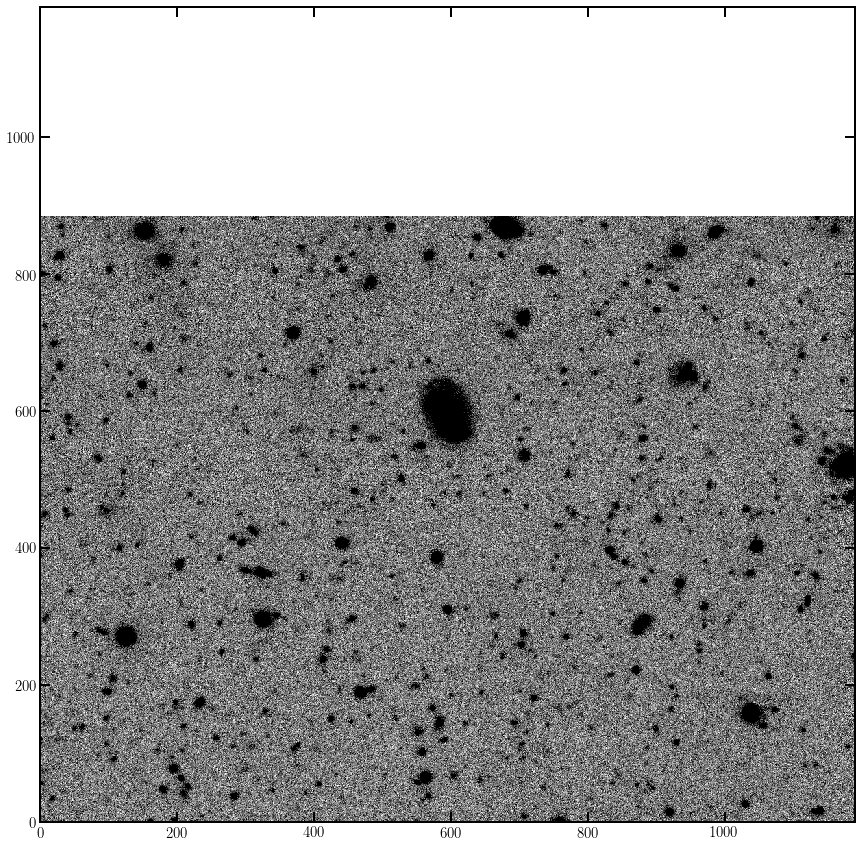

In [40]:
vmin, vmax = np.percentile(exp.getImage().getArray(), [1, 95])
plt.figure(figsize=(15, 15))
plt.imshow(cutout.getImage().getArray(), vmin=vmin, vmax=vmax, origin='lower', cmap='gray_r');

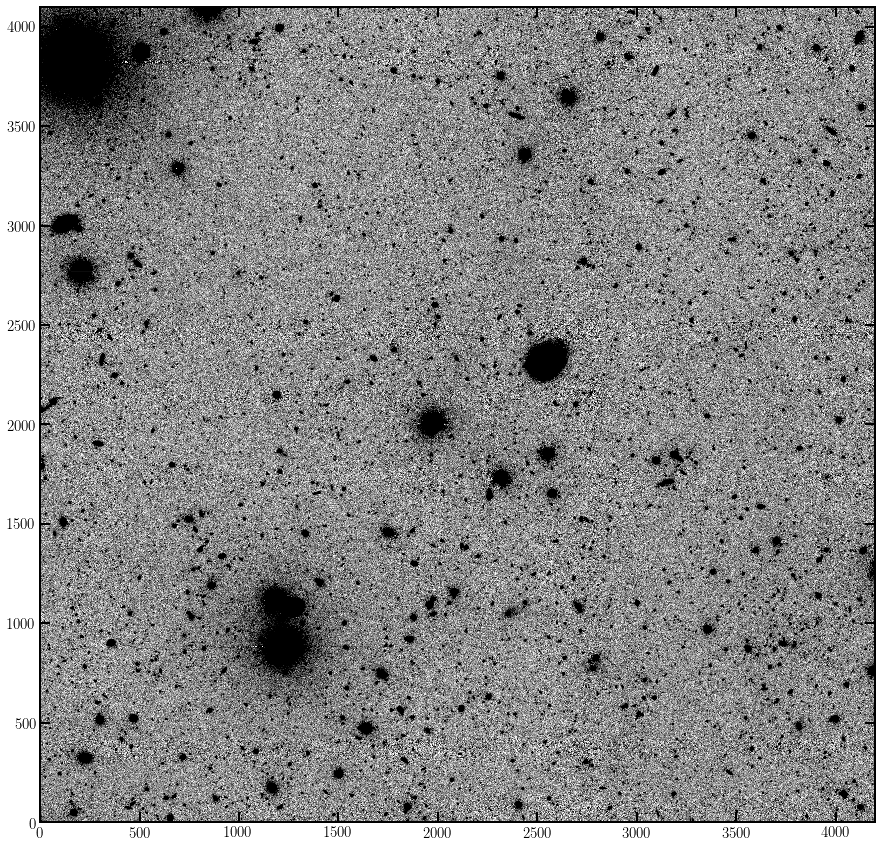

In [98]:
vmin, vmax = np.percentile(exp.getImage().getArray(), [1, 95])
plt.figure(figsize=(15, 15))
plt.imshow(exp.getImage().getArray(), vmin=vmin, vmax=vmax, origin='lower', cmap='gray_r');

In [7]:
coord = afwGeom.SpherePoint(cat[idx]['ra']*afwGeom.degrees, cat[idx]['dec']*afwGeom.degrees)

NameError: name 'idx' is not defined

In [78]:
wcs = exp.getWcs()
pix = wcs.skyToPixel(coord)
pix = afwGeom.Point2I(pix)
bbox = afwGeom.Box2I(pix, pix)

size = int(40/0.168)


bbox.grow(size)
cut = exp.Factory(exp, bbox, afwImage.PARENT)

LengthError: 
  File "src/image/Image.cc", line 89, in static lsst::afw::image::ImageBase<PixelT>::_view_t lsst::afw::image::ImageBase<PixelT>::_makeSubView(const Extent2I&, const Extent2I&, const _view_t&) [with PixelT = float; lsst::afw::image::ImageBase<PixelT>::_view_t = boost::gil::image_view<boost::gil::memory_based_2d_locator<boost::gil::memory_based_step_iterator<boost::gil::pixel<float, boost::gil::layout<boost::mpl::vector1<boost::gil::gray_color_t> > >*> > >; lsst::geom::Extent2I = lsst::geom::Extent<int, 2>]
    Box2I(Point2I(1373,-29259),lsst::geom::Extent2I(477,477)) doesn't fit in image 4200x4200 {0}
lsst::pex::exceptions::LengthError: 'Box2I(Point2I(1373,-29259),lsst::geom::Extent2I(477,477)) doesn't fit in image 4200x4200'


In [65]:
exp.getBBox

<bound method PyCapsule.getBBox of <lsst.afw.image.exposure.exposure.ExposureF object at 0x2ae95c134768>>

In [63]:
cat[idx]['tract', 'patch']

<Row index=131076>
tract patch
int64  str3
----- -----
 9469   7,7

In [133]:
    stamp = lsstutils.make_stamp(cat[idx]['ra'], cat[idx]['dec'], 100, 'g',
                                 root=ROOT, skymap=skymap, butler=butler)



In [53]:
cat[idx]['ra'], cat[idx]['dec']

(359.4628332, -0.1483936)

In [ ]:
exp

In [119]:
rgb = afwRgb.makeRGB(imageR=stamps['r'], 
                     imageG=stamps['i'], 
                     imageB=None,#stamps['g'], 
                     dataRange=0.6, Q=8)

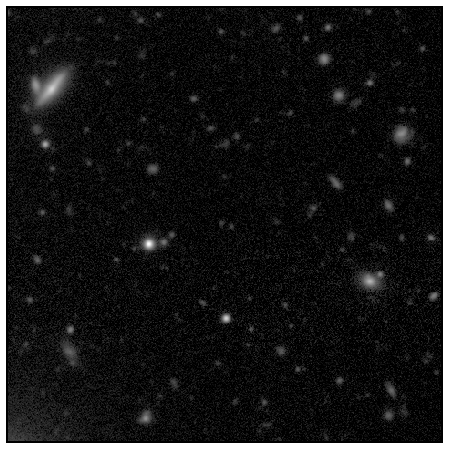

In [120]:
plt.figure(figsize=(8, 8))

plt.imshow(rgb, origin='lower')
plt.gca().set(xticks=[], yticks=[]);

In [115]:
vmin, vmax = np.percentile(stamps['r'].getImage().getArray(), [0.1, 99.9])

In [134]:
single_band_img = stamp.getImage().getArray()

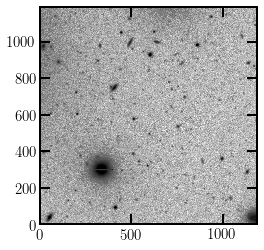

In [135]:
plt.imshow(single_band_img, 
           norm=colors.SymLogNorm(linthresh=0.1, vmin=vmin, vmax=vmax), 
           origin='lower', cmap='gray_r');

In [ ]:
if img is not None:

    fig, ax = plt.subplots(
        subplot_kw={'yticks':[], 'xticks':[]})
    ax.imshow(img, origin='lower')

    if scale:
        shape = img.shape
        xmin = 15.0
        xmax = xmin + scale/0.168
        y=0.93*shape[0]
        ax.axhline(y=y, xmin=xmin/shape[1], xmax=xmax/shape[1],
                   color='w', lw=3.0, zorder=1000)
        label = str(int(scale))
        ax.text((xmin+xmax)/2 - 0.042*shape[1], y - 0.072*shape[0],
                r'$'+label+'^{\prime\prime}$', color='w', fontsize=20)

    if ell_pars is not None:
        _draw_ellipse(ra, dec, ell_pars, wcs, ax, alpha=0.8, zorder=100)

    if full_cat is not None:
        ra_c, dec_c = wcs.getSkyOrigin()
        ra_c = ra_c.asDegrees()
        dec_c = dec_c.asDegrees()
        seps = angsep(ra_c, dec_c, full_cat['ra'], full_cat['dec'])
        src_cut= seps < 2 * radius
        sources = full_cat[src_cut]
        for src in sources:
            ell_pars = src['flux_radius_ave_g'], src['theta_image'],\
                       src['ellipticity'], ell_scale
            _draw_ellipse(src['ra'], src['dec'], ell_pars, wcs,
                          ax, color='lightgray', alpha=0.7, zorder=10)